In [1]:
# Standard libraries
import pandas
import numpy

# From this repository
from library.preprocess import load_spike_trains, extract_binned_spike_signals

# Spiking data 
fn_data = "/gpfs/bbp.cscs.ch/data/scratch/proj9/bisimplices/bbp_workflow/7b381e96-91ac-4ddd-887b-1f563872bd1c/toposample_input/raw_spikes_exc.npy"

# Bin size
bin_size = 5.0
bin_size_str = "5p0"

# Number of shuffled controls
n_ctrl = 10

# Load spiking data
spikes, gids, t_max = load_spike_trains(fn_data)
t_max = numpy.ceil(t_max) + 1 # Not sure if this is needed.

Here, we define a function to define the population coupling.
Population coupling of a neuron is the correlation between its binned spike train and the mean binned spike train of all other neurons (i.e. the population).

This means that when calculating the mean population activity, we should take out the contribution of the neuron in question. However, doing so would be very expensive. Additionally, considering that we analyze hundreds of thousands of neurons, the contribution of any single cell is negligible. By not subtracting the individual neuron contributions from the population activity, we can calculate everything in a single dot product.

In [2]:
def population_coupling(spikes, gids, t_max):
    print("Binning...")
    binned_sp, t_bins = extract_binned_spike_signals(spikes, gids, t_max, bin_size=bin_size)
    print("Done! Subtracting mean...")
    binned_sp = binned_sp - binned_sp.mean(axis=1, keepdims=True)
    print("Done! Calculating mean activity...")
    mn_pop = binned_sp.mean(axis=0)
    print("Done! Calculating dot product...")
    A = numpy.dot(binned_sp, mn_pop.reshape((-1, 1)))[:, 0]
    print("Done! Calculating variance for normalization...")
    B = numpy.sqrt(numpy.var(mn_pop) * numpy.var(binned_sp, axis=1)) * binned_sp.shape[1]
    print("Done!")
    return A / B

Calculate coupling for all neurons

In [3]:
CC_data = population_coupling(spikes, gids, t_max)

Binning...
Done! Subtracting mean...
Done! Calculating mean activity...
Done! Calculating dot product...
Done! Calculating variance for normalization...
Done!


Calculate controls and assemble a dataframe

In [4]:
CC_ctrl = {}
for i in range(n_ctrl):
    spikes_shuff = numpy.vstack([
            spikes[:, 0],
    spikes[numpy.random.permutation(spikes.shape[0]), 1]
    ]).transpose()
    CC_ctrl["Shuffled {0}".format(i)] = population_coupling(spikes_shuff, gids, t_max)
    
CC_ctrl = pandas.DataFrame(CC_ctrl, index=pandas.Index(gids, name="gid"))

Binning...
Done! Subtracting mean...
Done! Calculating mean activity...
Done! Calculating dot product...
Done! Calculating variance for normalization...
Done!
Binning...
Done! Subtracting mean...
Done! Calculating mean activity...
Done! Calculating dot product...
Done! Calculating variance for normalization...
Done!
Binning...
Done! Subtracting mean...
Done! Calculating mean activity...
Done! Calculating dot product...
Done! Calculating variance for normalization...
Done!
Binning...
Done! Subtracting mean...
Done! Calculating mean activity...
Done! Calculating dot product...
Done! Calculating variance for normalization...
Done!
Binning...
Done! Subtracting mean...
Done! Calculating mean activity...
Done! Calculating dot product...
Done! Calculating variance for normalization...
Done!
Binning...
Done! Subtracting mean...
Done! Calculating mean activity...
Done! Calculating dot product...
Done! Calculating variance for normalization...
Done!
Binning...
Done! Subtracting mean...
Done! Cal

Plot to get an overview of the data

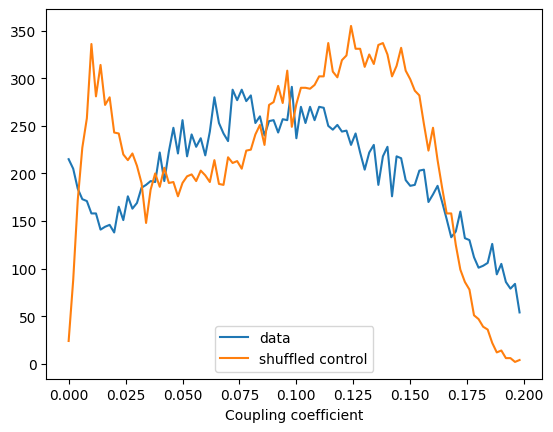

In [5]:
from matplotlib import pyplot as plt

bins = numpy.linspace(0, 0.2, 101)
plt.plot(bins[:-1], numpy.histogram(CC_data, bins=bins)[0], label="data")
plt.plot(bins[:-1], numpy.histogram(numpy.mean(CC_ctrl.values, axis=1),
                                    bins=bins)[0], label="shuffled control")
plt.gca().set_xlabel("Coupling coefficient")
plt.legend()

In [6]:
CC = CC_ctrl.copy()
CC["data"] = CC_data

out_fn = "/gpfs/bbp.cscs.ch/data/scratch/proj9/bisimplices/bbp_workflow/7b381e96-91ac-4ddd-887b-1f563872bd1c/working_dir/coupling_coefficients.h5"
CC.to_hdf(out_fn, key="CC_bin_sz_{0}".format(bin_size_str))